In [1]:
import os
import math
import time
import random
import scipy
import regex as re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
import textstat
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer


import pyphen
import syllapy
from spellchecker import SpellChecker

import spacy
#python3 -m spacy download en_core_web_md
from itertools import combinations


# import gingerit
# import languagetool_python

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package punkt to /Users/yli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/yli/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/yli/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
raw_training_set = pd.read_csv('asap-aes/training_set_rel3.tsv',sep='\t', encoding='latin1')

In [11]:
# read the intermediate from the simple_feature_extraction script
basic_feature_train_df = pd.read_csv('basic_feature_train_data.csv') 

# to reduce computation time, I tested with the first 1000 rows only
#basic_feature_train_df = basic_feature_train_df[basic_feature_train_df['essay_set'].isin([1])]
basic_feature_train_df = basic_feature_train_df.head(3000)
basic_feature_train_df = basic_feature_train_df[~(basic_feature_train_df['essay_id'] == 10001)] # the text is "NO IMAGE"
print(basic_feature_train_df.shape)
basic_feature_train_df.head()

(3000, 24)


,essay_id,essay_set,text_set,text,word_tokens,sent_tokens,word_tokens_clean,word_count,sent_count,char_count,...,DalCha_score,unique_word_count,neg,neu,pos,compound,cohesion,AoA_score,domain1_score,domain2_score
0,1,1,text_set1,"dear local newspaper, i think effects computer...","['dear', 'local', 'newspaper', ',', 'i', 'thin...","['dear local newspaper, i think effects comput...","['dear', 'local', 'newspaper', 'i', 'think', '...",112,7,624,...,8.13,75,0.000,0.847,0.153,0.9550,0.248577,5.925000,8,NaN
1,2,1,text_set1,dear i believe that using computers will benef...,"['dear', 'i', 'believe', 'that', 'using', 'com...",['dear i believe that using computers will ben...,"['dear', 'i', 'believe', 'that', 'using', 'com...",136,8,767,...,7.50,90,0.015,0.787,0.198,0.9678,0.312173,6.014722,9,NaN
2,3,1,text_set1,"dear, more and more people use computers, but ...","['dear', ',', 'more', 'and', 'more', 'people',...","['dear, more and more people use computers, bu...","['dear', 'more', 'and', 'more', 'people', 'use...",91,7,519,...,7.61,70,0.016,0.670,0.314,0.9896,0.313247,5.671034,7,NaN
3,4,1,text_set1,"dear local newspaper, i have found that many e...","['dear', 'local', 'newspaper', ',', 'i', 'have...","['dear local newspaper, i have found that many...","['dear', 'local', 'newspaper', 'i', 'have', 'f...",161,8,922,...,8.65,107,0.024,0.762,0.214,0.9891,0.237326,6.175490,10,NaN
4,5,1,text_set1,dear i know having computers has a positive ef...,"['dear', 'i', 'know', 'having', 'computers', '...",['dear i know having computers has a positive ...,"['dear', 'i', 'know', 'having', 'computers', '...",153,9,823,...,6.85,90,0.000,0.816,0.184,0.9828,0.244275,5.864906,8,NaN


In [12]:
# generate N-grams

vectorizer = TfidfVectorizer(ngram_range=(2, 2), min_df = 2, stop_words='english')  # Generates bigrams only
# Transform the text data into a feature matrix
bigrams_feature_X = vectorizer.fit_transform(basic_feature_train_df['text'])

# min_df and max_df are supposed to limit the number of ngrams generated
# for example, min_df = 2 means the ngram has to appear in at least two essays to be counted
# max_df = 0.8 means ngrams appearing in >80% of the essays will not be counted
# however it didn't really make much of a difference to the number of columns
# removing stop_words reduced the number of columns by about 30%

print("Feature names (n-grams):", vectorizer.get_feature_names_out())
print("Feature matrix:\n", bigrams_feature_X.toarray())

# ngrams_feature_X will be a sparse matrix with #row = #rows in input df, #columns = # of unique bigrams/trigrams
# with 800 rows in the input data (200 raw essays), and generating both bigrams and trigrams, the feature matrix has >90k column
# with bigrams only, it's about 30k columns

# since it is sparse, apparently some models like random forest do not handle sparse matrices well
# although svm is supposed to work well with sparse matrices
# I used truncated SVD to reduce the number of dimensions
# because apparently truncated SVD work better than PCA on sparse matrices 

bigrams_feature_X.shape

Feature names (n-grams): ['abhor exactly' 'abhor right' 'ability access' ... 'younger people'
 'younger readers' 'younger years']
Feature matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(3000, 14271)

In [19]:
# test the number of components we should keep for the feature matrix

start_time = time.time() 

n_comp_ls = [int(x) for x in np.linspace(1000, 3000, int(2000/250)+1)]
explained_var_ls = []

for n_components in n_comp_ls:
    svd = TruncatedSVD(n_components=n_components)  # Adjust n_components based on dataset size
    X_reduced = svd.fit_transform(bigrams_feature_X)
#    print(X_reduced.shape)
    
    explained_variance = svd.explained_variance_ratio_.sum()
    print(f"{n_components} components has total explained variance: {explained_variance:.2f}")
    explained_var_ls.append(explained_variance)

end_time = time.time()
execution_time = end_time - start_time
print(f"Time taken for SVD decomposition testing: {execution_time:.5f} seconds")


1000 components has total explained variance: 0.59
1250 components has total explained variance: 0.67
1500 components has total explained variance: 0.74
1750 components has total explained variance: 0.80
2000 components has total explained variance: 0.86
2250 components has total explained variance: 0.90
2500 components has total explained variance: 0.94
2750 components has total explained variance: 0.98
3000 components has total explained variance: 1.00
Time taken for SVD decomposition testing: 138.98980 seconds


Text(0.5, 1.0, 'Dimension Reduction for Bi-gram Feature Vector')

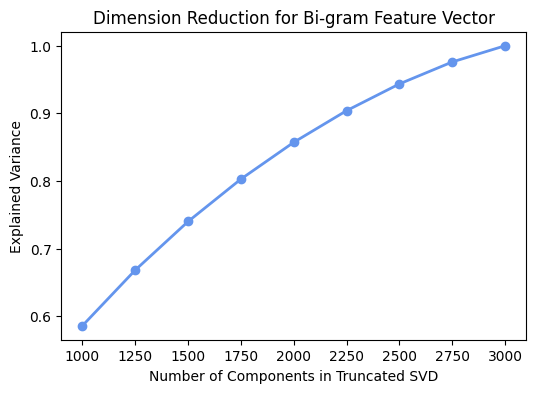

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(n_comp_ls, explained_var_ls, marker='o', color='cornflowerblue', linestyle='-', linewidth=2)
#plt.bar(n_comp_ls, explained_var_ls, color='cornflowerblue', width = 25)

plt.xlabel("Number of Components in Truncated SVD")
plt.ylabel("Explained Variance")
plt.title("Dimension Reduction for Bi-gram Feature Vector")

# looks like we need significantly more components when the original sparse matrix is large
# with 800 data points, 600 components was able to reach 99% variance
# it also gets really slow when the data points are large

In [22]:
#test a number of n_components, plot the elbow chart for explained variance
svd = TruncatedSVD(n_components=2500)  # Adjust n_components based on dataset size
bigrams_X_reduced = svd.fit_transform(bigrams_feature_X)
print(bigrams_X_reduced.shape)

explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total explained variance: {explained_variance:.2f}")

bigrams_training_df = pd.merge(basic_feature_train_df[['essay_id', 'essay_set', 'text_set']], 
                               pd.DataFrame(bigrams_X_reduced), left_index=True, right_index=True)
bigrams_training_df.head()

(3000, 2500)
Total explained variance: 0.94


,essay_id,essay_set,text_set,0,1,2,3,4,5,6,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,1,1,text_set1,0.069907,-0.056707,-0.043225,0.040636,-0.002630,-0.014723,0.019292,...,0.004144,0.008705,-0.010860,-0.015987,-0.006174,-0.001504,-0.007293,0.007667,-0.018343,0.019696
1,2,1,text_set1,0.084405,-0.041616,-0.038028,0.043764,0.000938,-0.072060,-0.061746,...,-0.004893,-0.016607,-0.000679,-0.000764,0.008135,0.025086,0.000979,-0.012835,0.025781,0.020648
2,3,1,text_set1,0.217846,-0.123239,-0.111626,0.038975,-0.001208,0.177371,-0.190543,...,0.000949,0.022810,-0.004465,-0.004339,-0.005875,-0.005550,0.015593,-0.003677,0.000493,-0.006251
3,4,1,text_set1,0.072207,-0.041930,-0.037298,0.050166,-0.000711,-0.058569,-0.044982,...,0.008273,-0.010141,-0.015993,0.005722,-0.008396,0.001413,0.002979,-0.014301,0.000513,-0.017856
4,5,1,text_set1,0.078085,-0.017194,-0.019008,0.081515,-0.003172,0.108176,-0.015846,...,0.010593,-0.020633,-0.011990,0.003098,0.013955,0.019009,0.004033,-0.001828,0.013169,-0.001103


In [23]:
vectorizer = TfidfVectorizer(ngram_range=(3, 3))  # Generates unigrams, bigrams, and trigrams

# Transform the text data into a feature matrix
trigrams_feature_X = vectorizer.fit_transform(basic_feature_train_df['text'])
print("Feature names (n-grams):", vectorizer.get_feature_names_out())
print("Feature matrix:\n", trigrams_feature_X.toarray())

trigrams_feature_X.shape

Feature names (n-grams): ['_________ censorship in' 'aa day is' 'aa stated in' ... 'zoning out in'
 'zoo instead of' 'zoom all the']
Feature matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(3000, 227388)

In [24]:
# test the number of components we should keep for the feature matrix

start_time = time.time() 

n_comp_ls = [int(x) for x in np.linspace(1000, 3000, int(2000/250)+1)]
explained_var_trigrams_ls = []

for n_components in n_comp_ls:
    svd = TruncatedSVD(n_components=n_components)  # Adjust n_components based on dataset size
    X_reduced = svd.fit_transform(trigrams_feature_X)
#    print(X_reduced.shape)
    
    explained_variance = svd.explained_variance_ratio_.sum()
    print(f"{n_components} components has total explained variance: {explained_variance:.2f}")
    explained_var_trigrams_ls.append(explained_variance)

end_time = time.time()
execution_time = end_time - start_time
print(f"Time taken for SVD decomposition testing: {execution_time:.5f} seconds")

## I stopped running this because it was taking too long and heating up my laptop

1000 components has total explained variance: 0.39
1250 components has total explained variance: 0.47
1500 components has total explained variance: 0.55
1750 components has total explained variance: 0.63
2000 components has total explained variance: 0.71
2250 components has total explained variance: 0.78


KeyboardInterrupt: 

Text(0.5, 1.0, 'Dimension Reduction for Tri-gram Feature Vector')

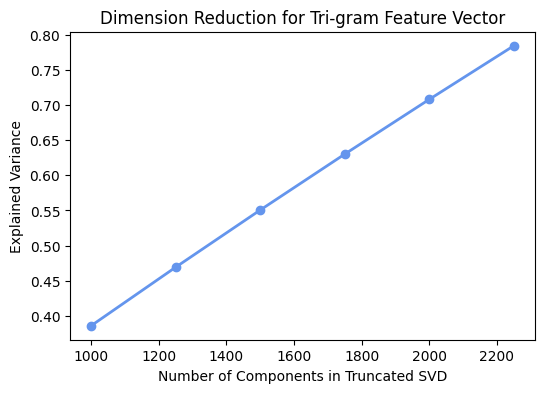

In [27]:
plt.figure(figsize=(6, 4))
plt.plot(n_comp_ls[:6], explained_var_trigrams_ls, marker='o', color='cornflowerblue', linestyle='-', linewidth=2)
#plt.bar(n_comp_ls, explained_var_ls, color='cornflowerblue', width = 25)

plt.xlabel("Number of Components in Truncated SVD")
plt.ylabel("Explained Variance")
plt.title("Dimension Reduction for Tri-gram Feature Vector")

# looks like 600 components is definitely enough, question is we want to go even lower 

In [ ]:
#test a number of n_components, plot the elbow chart for explained variance
svd = TruncatedSVD(n_components=3000)  # Adjust n_components based on dataset size
trigrams_X_reduced = svd.fit_transform(trigrams_feature_X)
print(trigrams_X_reduced.shape)

explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total explained variance: {explained_variance:.2f}")

trigrams_training_df = pd.merge(basic_feature_train_df[['essay_id', 'essay_set', 'text_set']], 
                               pd.DataFrame(trigrams_X_reduced), left_index=True, right_index=True)
trigrams_training_df.head()